In [2]:
import numpy as np
import pandas as pd
import os
print(os.listdir(".\input"))

['usps.h5']


In [3]:
import h5py 
from functools import reduce

def getUspDataSet(path):
    with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        x_Train = train.get("data")[:]
        y_Train = train.get("target")[:]
        test = hf.get('test')
        x_Test = test.get("data")[:]
        y_Test = test.get("target")[:]
    return x_Train, y_Train, x_Test, y_Test

In [4]:
import matplotlib.pyplot as plt

def plot_image(image):
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    plt.imshow(image, cmap='binary')
    plt.show()

In [5]:
import matplotlib.pyplot as plt

def plot_images_labels_prediction(images,labels,
                                  prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images.iloc[idx, np.arange(0, 256)].as_matrix().reshape([16, 16]), cmap='binary')
        title= "label=" +str(labels.iloc[idx,0])
        if len(prediction)>0:
            title+=",predict="+str(prediction.iloc[idx,0]) 
            
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

In [6]:
# 2-norm

def norm2 (a, ak):
    return np.linalg.norm(a-ak, 2)

In [7]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [8]:
x_Train_data = pd.concat([pd.DataFrame(x_Train),pd.DataFrame(y_Train, columns=['digital'])], axis=1)
x_Test_data = pd.concat([pd.DataFrame(x_Test),pd.DataFrame(y_Test, columns=['digital'])], axis=1)

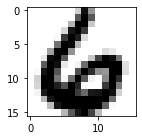

In [9]:
plot_image(x_Train_data.iloc[0, np.arange(0, 256)].as_matrix().reshape([16, 16]))

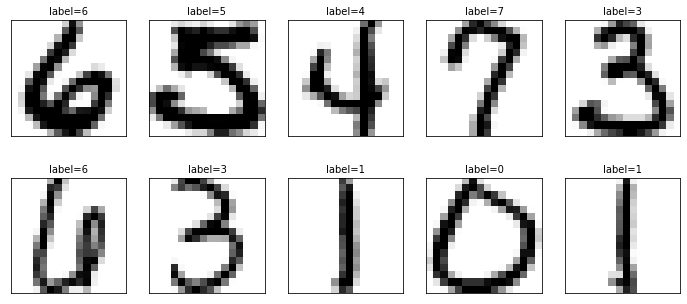

In [10]:
plot_images_labels_prediction(x_Train_data.loc[:,np.arange(0, 256)], x_Train_data.loc[:,['digital']],[],0,)

In [11]:
feature_names = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Total'])

table = np.zeros((2, 11))

for i in range(11):
    table[0][i] = x_Train_data[x_Train_data['digital'] == i].shape[0]
    table[1][i] = x_Test_data[x_Test_data['digital'] == i].shape[0]
    if i == 10:
        table[0][i] = x_Train_data.shape[0]
        table[1][i] = x_Test_data.shape[0]

pd.DataFrame(table, columns=feature_names)

,0,1,2,3,4,5,6,7,8,9,Total
0,1194.0,1005.0,731.0,658.0,652.0,556.0,664.0,645.0,542.0,644.0,7291.0
1,359.0,264.0,198.0,166.0,200.0,160.0,170.0,147.0,166.0,177.0,2007.0


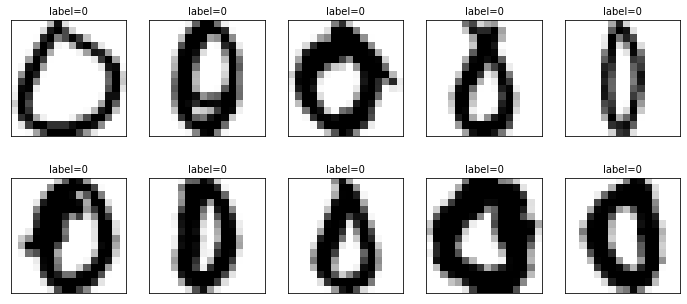

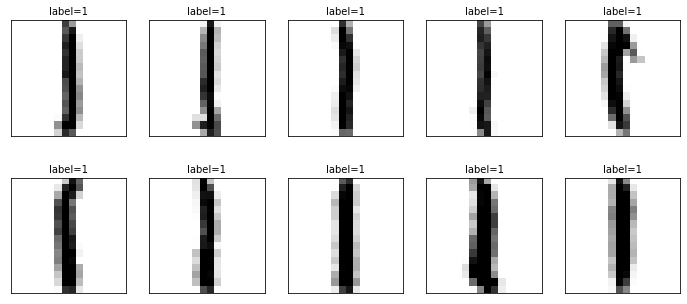

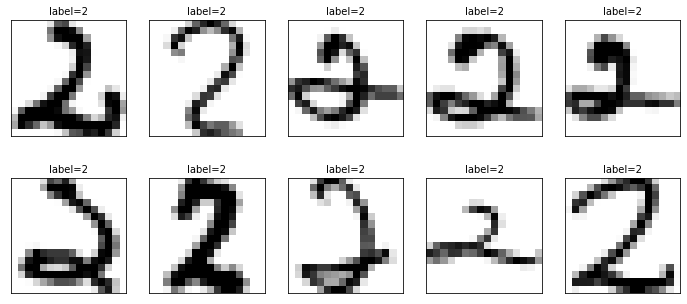

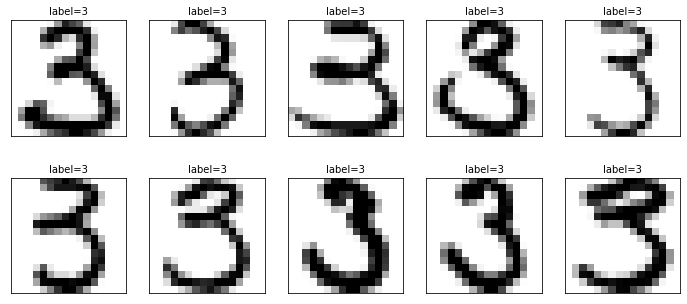

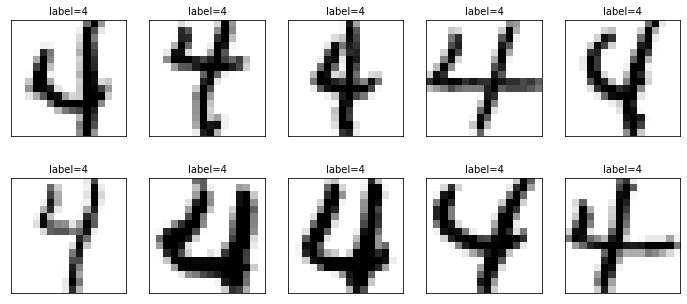

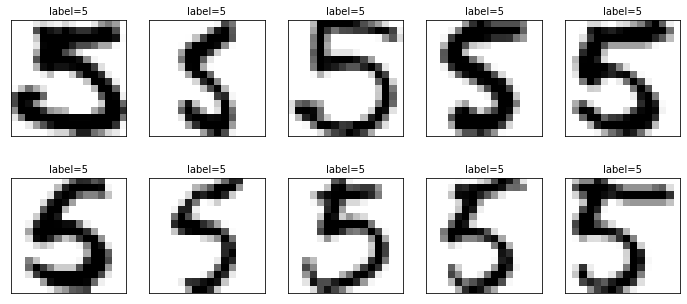

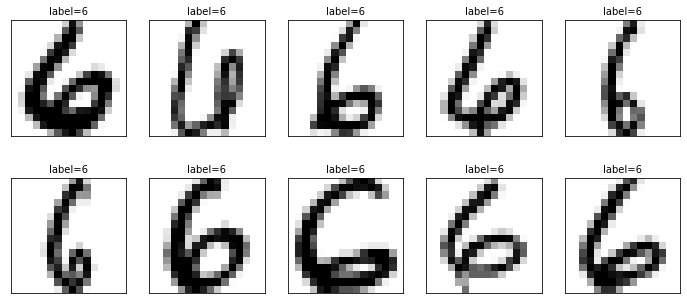

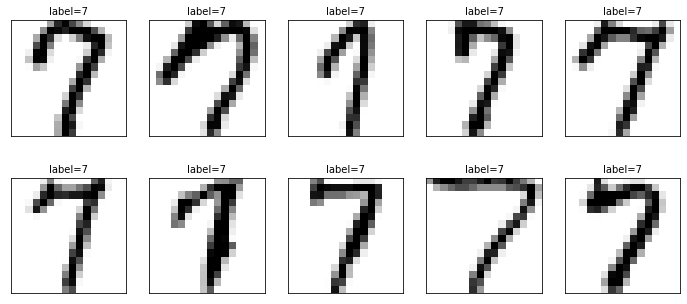

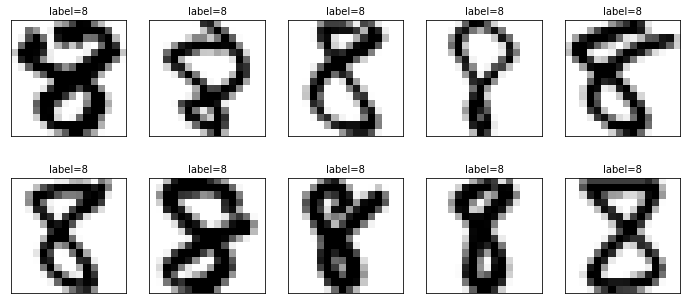

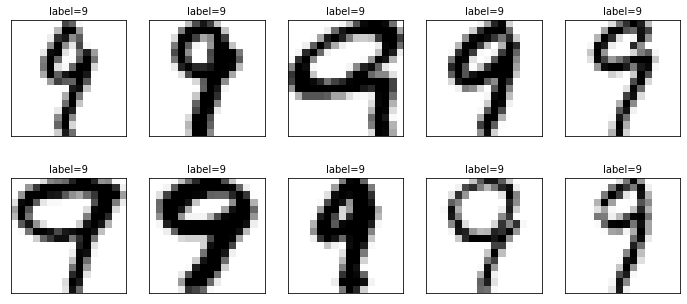

In [12]:
for i in range(0,10):
    plot_images_labels_prediction(x_Train_data[x_Train_data['digital'] == i].loc[:,np.arange(0, 256)], x_Train_data[x_Train_data['digital'] == i].loc[:,['digital']],[],0,)

# Handwritten Digits and a Simple Algorithm

### 透過 training set 取得手寫數字0~9的平均值陣列
### 將 testing set 每一張手寫數字與0~9平均值陣列比對，取最小的2norm，預測該張手寫數字代表的數字

In [13]:
meanDigitalTable = np.zeros((10, 257))

for i in range(10):
    for j in range(257):       
        if j == 256:
            meanDigitalTable[i][j] = int(i)
        else:
            meanDigitalTable[i][j] = x_Train_data[x_Train_data['digital'] == i].loc[:,np.arange(0, 256)].mean(axis = 0)[j]

x_Train_mean = pd.DataFrame(meanDigitalTable, columns=np.arange(0, 257))

In [14]:
x_Train_mean

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0.000686,0.002301,0.007539,0.029374,0.083329,0.214289,0.434208,0.576304,0.523142,0.323150,...,0.764013,0.719526,0.521245,0.266493,0.087247,0.016245,0.001737,3.182578e-05,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000002,0.006361,0.182422,0.738624,0.499852,0.059166,...,0.575412,0.754635,0.216239,0.019953,0.001869,0.000331,0.000234,0.000000e+00,0.000000,1.0
2,0.003756,0.019804,0.048712,0.100327,0.198269,0.313164,0.402113,0.423611,0.339817,0.187809,...,0.159382,0.109233,0.081786,0.078753,0.102215,0.140904,0.138408,8.737891e-02,0.025574,2.0
3,0.001242,0.009779,0.043731,0.134705,0.290489,0.448433,0.579752,0.669148,0.673355,0.563835,...,0.705606,0.651247,0.520860,0.352631,0.195606,0.089490,0.033318,7.094225e-03,0.000089,3.0
4,0.000000,0.000457,0.004272,0.020956,0.060340,0.107799,0.091428,0.077067,0.086249,0.130354,...,0.241591,0.326567,0.282333,0.163329,0.071298,0.028863,0.007327,2.269172e-03,0.000263,4.0
5,0.000271,0.002451,0.014165,0.033097,0.058937,0.098799,0.146969,0.233636,0.316099,0.395971,...,0.641636,0.643503,0.567831,0.409600,0.244072,0.110748,0.038295,9.165468e-03,0.000859,5.0
6,0.000000,0.000000,0.000000,0.000455,0.003624,0.016902,0.065898,0.214449,0.438809,0.468583,...,0.722267,0.618303,0.402012,0.190471,0.071111,0.015579,0.002254,7.530023e-07,0.000000,6.0
7,0.012542,0.060091,0.118027,0.198057,0.291024,0.351520,0.381180,0.397761,0.428757,0.457081,...,0.535655,0.373432,0.096324,0.011988,0.002297,0.000408,0.000000,0.000000e+00,0.000000,7.0
8,0.000749,0.007785,0.030420,0.085137,0.199803,0.370611,0.550061,0.634461,0.606877,0.468825,...,0.791119,0.782972,0.539287,0.231089,0.071608,0.014589,0.002356,1.844995e-06,0.000000,8.0
9,0.000050,0.000721,0.002192,0.009234,0.030633,0.109248,0.301347,0.582744,0.786199,0.759811,...,0.490326,0.462094,0.212839,0.063462,0.018492,0.004843,0.001668,5.302795e-04,0.000000,9.0


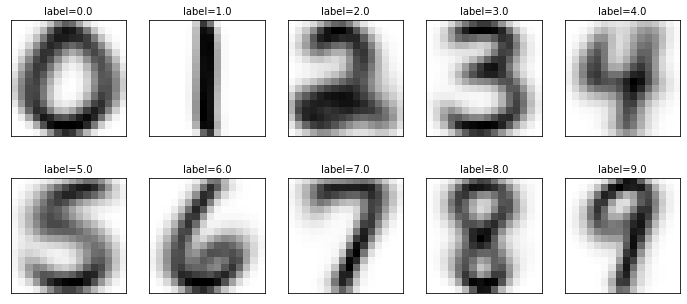

In [15]:
plot_images_labels_prediction(x_Train_mean.loc[:,np.arange(0, 256)], x_Train_mean.loc[:,[256]],[],0,10)

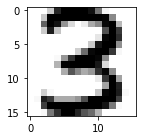

In [16]:
plot_image(x_Test_data.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]))

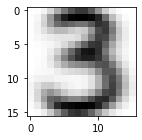

In [17]:
plot_image(x_Train_mean.iloc[3, np.arange(0, 256)].as_matrix().reshape([16, 16]))

In [18]:
norm2(x_Test_data.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]), x_Train_mean.iloc[3, np.arange(0, 256)].as_matrix().reshape([16, 16]))

3.094884822357467

In [19]:
def simpleAlgorithm(x_Test_data, x_Train_mean):

    total = x_Test_data.shape[0]
    isSuccess = 0
    isError = 0
    normList = np.zeros((1, 10))
    result = np.zeros((total, 1))

    for i in range(0, total):

        for j in range(0,10):
            normList[0][j] = norm2(x_Test_data.iloc[i, np.arange(0, 256)].as_matrix().reshape([16, 16]), x_Train_mean.iloc[j, np.arange(0, 256)].as_matrix().reshape([16, 16]))

        prediction = np.where(normList == np.amin(normList))

        result[i][0] = int(prediction[1])

    return pd.concat([x_Test_data, pd.DataFrame(result, columns=['prediction'])], axis=1)

In [20]:
x_Test_Prediction = simpleAlgorithm(x_Test_data, x_Train_mean)

In [21]:
x_Test_Prediction[x_Test_Prediction['digital'] == x_Test_Prediction['prediction']].shape[0]/x_Test_Prediction.shape[0]

0.7767812655705032

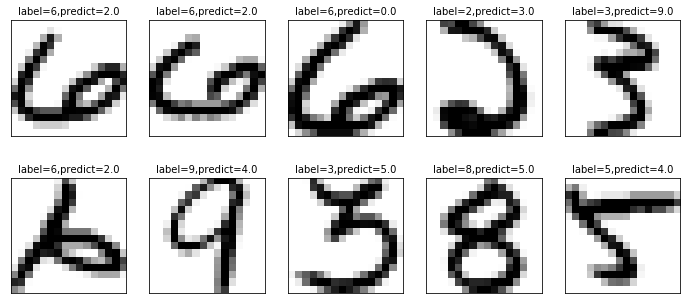

In [22]:
errorList = x_Test_Prediction[x_Test_Prediction['digital'] != x_Test_Prediction['prediction']]

plot_images_labels_prediction(errorList.iloc[:,np.arange(0, 256)], errorList.iloc[:,[256]], errorList.iloc[:,[257]],0,10)

In [23]:
temp = errorList[['digital', 'prediction']].groupby(['digital', 'prediction']).size().reset_index(name='counts')

errorPrediction = np.zeros((4, 10))

for i in range(0,10):
    errorPrediction[0][i] = temp[temp['digital'] == i].sort_values(['digital', 'counts'], ascending=[True, False]).iloc[0][1]
    errorPrediction[1][i] = temp[temp['digital'] == i].sort_values(['digital', 'counts'], ascending=[True, False]).iloc[0][2]
    errorPrediction[2][i] = temp[temp['digital'] == i].sort_values(['digital', 'counts'], ascending=[True, False]).iloc[1][1]
    errorPrediction[3][i] = temp[temp['digital'] == i].sort_values(['digital', 'counts'], ascending=[True, False]).iloc[1][2]

pd.DataFrame(errorPrediction, columns=np.arange(0, 10)) 

,0,1,2,3,4,5,6,7,8,9
0,6.0,6.0,4.0,5.0,9.0,3.0,0.0,9.0,5.0,4.0
1,35.0,3.0,16.0,21.0,31.0,17.0,10.0,13.0,15.0,15.0
2,5.0,9.0,3.0,0.0,2.0,0.0,5.0,4.0,2.0,8.0
3,8.0,3.0,13.0,9.0,9.0,12.0,9.0,6.0,9.0,8.0


# Classification Using SVD Bases

In [381]:
def getUList(x_Data, y_Data):
    # We now normalize all values between 0 and 1 and we now flatten the 16 × 16 images into vectors of size 256.

    x_Data = x_Data.astype('float32') / 255.
    x_Data = x_Data.reshape((len(x_Data), np.prod(x_Data.shape[1:])))
    x_Data = x_Data.T
    
    #  we now partition the x_train based on the ten classes and store in a list.

    x_list = []

    for k in range(10):
        components = np.where(y_Data == k)[0]
        x_list.append(x_Data[:, components])

    # we now create a svd basis for each digit data samples.

    U_list = []

    for k in range(10):
        U, S, V = np.linalg.svd(x_list[k])
        U_list.append(U)
    
    return U_list


def svdAlgorithm (x_Data, y_Data, U_list,basis):
    # We now normalize all values between 0 and 1 and we now flatten the 16 × 16 images into vectors of size 256.

    x_Data = x_Data.astype('float32') / 255.
    x_Data = x_Data.reshape((len(x_Data), np.prod(x_Data.shape[1:])))
    x_Data = x_Data.T

    # we now select the dominant orthogonal basis and project the digits on the reduced basis to compute the least square projection error.

    result_mse = []
    result_residual = []

    for r in range(basis):
        n_Data = x_Data.shape[1]
        y_predict = np.ones((n_Data))

        for i in range(0, n_Data):
            z = x_Data[:, i]
            residual_list = np.ones((10))

            for j in range(10):
                U_k = U_list[j][:, :r+1]
                residual = np.linalg.norm(z - np.dot(U_k, np.dot(U_k.T, z)))
                residual_list[j] = residual

            y_predict[i] = np.argmin(residual_list)

            if r == basis-1:
                result_residual.append(residual_list)

        result_mse.append(np.mean((y_Data/1.0 - y_predict/1.0) ** 2))

    return y_predict, result_residual, result_mse

In [382]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [383]:
U_list = getUList(x_Train, y_Train)

In [384]:
y_Train_predict, result_Train_residual, result_Train_mse = svdAlgorithm(x_Train, y_Train, U_list, 10)

In [385]:
result_Train_List = pd.concat([pd.DataFrame(y_Train_predict, columns=['prediction']),pd.DataFrame(y_Train, columns=['actual'])], axis=1)
result_Train = result_Train_List[result_Train_List['prediction'] == result_Train_List['actual']].shape[0]/result_Train_List.shape[0]
result_Train

0.9680427924838843

In [386]:
result_Train_List[result_Train_List['prediction'] != result_Train_List['actual']]

,prediction,actual
14,9.0,7
21,7.0,8
38,0.0,4
52,7.0,2
53,1.0,0
81,3.0,8
196,9.0,7
209,8.0,2
212,1.0,4
226,7.0,2


In [387]:
result_Train_residual[7290]

array([0.01962116, 0.00553887, 0.01741455, 0.01982266, 0.01237774,
       0.01933917, 0.01740003, 0.01780849, 0.01104562, 0.01503556])

In [388]:
result_Train_mse

[3.198052393361679,
 1.4978740913454944,
 1.2891235770127554,
 0.9462350843505692,
 0.7939925936085585,
 0.7944040597997531,
 0.7104649567960499,
 0.5841448360993005,
 0.5739953367164998,
 0.5336716499794267]

Text(0.5, 0, 'number of basis')

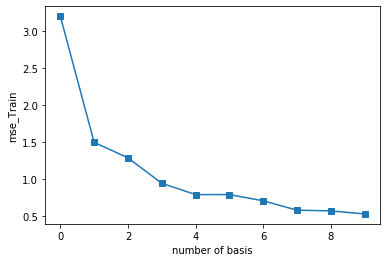

In [389]:
plt.plot(result_Train_mse,'s-')
plt.ylabel('mse_Train')
plt.xlabel('number of basis')

In [390]:
y_Test_predict, result_Test_residual, result_Test_mse = svdAlgorithm(x_Test, y_Test, U_list, 10)

In [391]:
result_Test_List = pd.concat([pd.DataFrame(y_Test_predict, columns=['prediction']),pd.DataFrame(y_Test, columns=['actual'])], axis=1)
result_Test = result_Test_List[result_Test_List['prediction'] == result_Test_List['actual']].shape[0]/result_Test_List.shape[0]
result_Test

0.9347284504235177

In [392]:
result_Test_List[result_Test_List['prediction'] != result_Test_List['actual']]

,prediction,actual
12,3.0,2
13,8.0,4
17,2.0,6
48,3.0,2
53,0.0,2
78,0.0,2
131,4.0,5
135,7.0,9
145,0.0,2
164,9.0,0


In [393]:
result_Test_residual[2006]

array([0.02037713, 0.00211659, 0.01747488, 0.0192784 , 0.0118814 ,
       0.01773486, 0.01526792, 0.01726207, 0.0146006 , 0.0146294 ])

In [394]:
result_Test_mse

[4.022421524663677,
 2.0269058295964126,
 1.8256103637269556,
 1.4867962132536123,
 1.2227204783258594,
 1.2825112107623318,
 1.1629297458893872,
 1.1031390134529149,
 1.0488290981564523,
 0.9725959142999502]

Text(0.5, 0, 'number of basis')

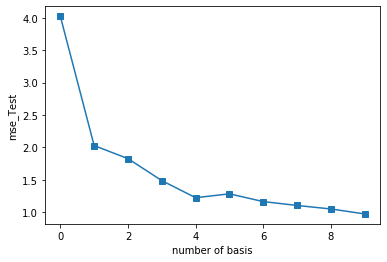

In [395]:
plt.plot(result_Test_mse,'s-')
plt.ylabel('mse_Test')
plt.xlabel('number of basis')

In [397]:
components = np.where(y_Test == 3)[0]
components
x_Test_3 = x_Test[components, :]
y_Test_3 = np.full(x_Test_3.shape[0],3)

In [398]:
y_Test_3_predict, result_Test_3_residual, result_Test_3_mse = svdAlgorithm(x_Test_3, y_Test_3, U_list, 10)

In [399]:
result_Test_3_List = pd.concat([pd.DataFrame(y_Test_3_predict, columns=['prediction']),pd.DataFrame(y_Test_3, columns=['actual'])], axis=1)
result_Test_3 = result_Test_3_List[result_Test_3_List['prediction'] == result_Test_3_List['actual']].shape[0]/result_Test_3_List.shape[0]
result_Test_3

0.8674698795180723

In [402]:
result_Test_3_List[result_Test_3_List['prediction'] != result_Test_3_List['actual']]

,prediction,actual
21,8.0,3
24,5.0,3
28,5.0,3
29,5.0,3
34,2.0,3
46,5.0,3
56,9.0,3
61,8.0,3
72,5.0,3
78,5.0,3


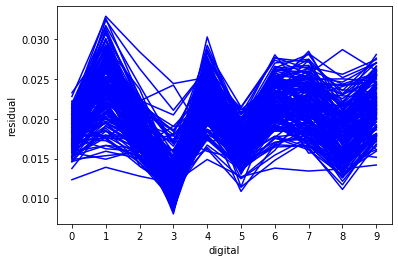

In [434]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_3.shape[0]):
    plt.plot(result_Test_3_residual[i],color = 'blue')

In [417]:
components = np.where(y_Test == 7)[0]
components
x_Test_7 = x_Test[components, :]
y_Test_7 = np.full(x_Test_7.shape[0],7)

In [418]:
y_Test_7_predict, result_Test_7_residual, result_Test_7_mse = svdAlgorithm(x_Test_7, y_Test_7, U_list, 10)

In [419]:
result_Test_7_List = pd.concat([pd.DataFrame(y_Test_7_predict, columns=['prediction']),pd.DataFrame(y_Test_7, columns=['actual'])], axis=1)
result_Test_7 = result_Test_7_List[result_Test_7_List['prediction'] == result_Test_7_List['actual']].shape[0]/result_Test_7_List.shape[0]
result_Test_7

0.9455782312925171

In [421]:
result_Test_7_List[result_Test_7_List['prediction'] != result_Test_7_List['actual']]

,prediction,actual
25,4.0,7
31,9.0,7
49,1.0,7
50,9.0,7
62,4.0,7
73,4.0,7
86,8.0,7
107,2.0,7


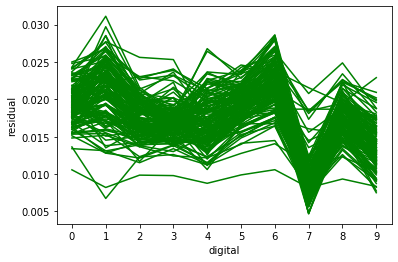

In [435]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_7.shape[0]):
    plt.plot(result_Test_7_residual[i], color = 'green')